-- 0 --


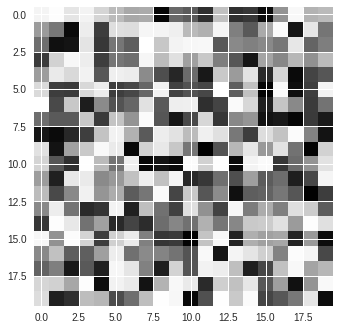

-- 10 --


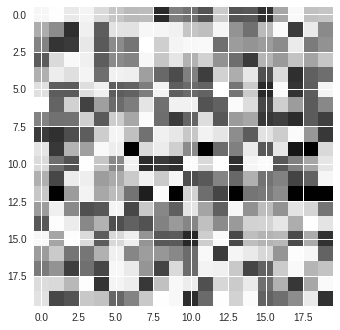

-- 20 --


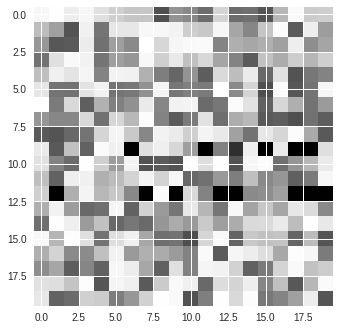

-- 30 --


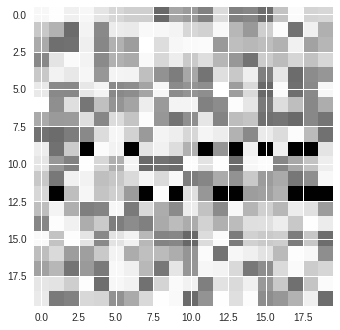

-- 40 --


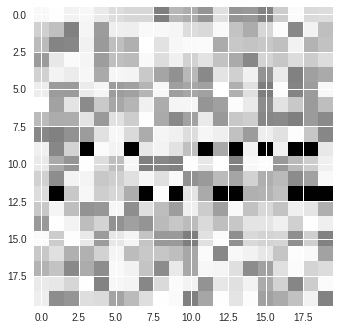

-- 50 --


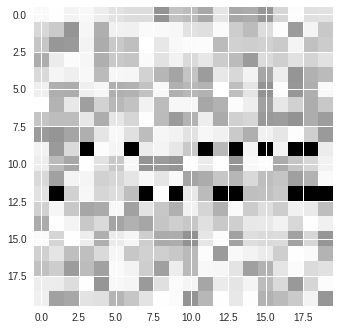

-- 60 --


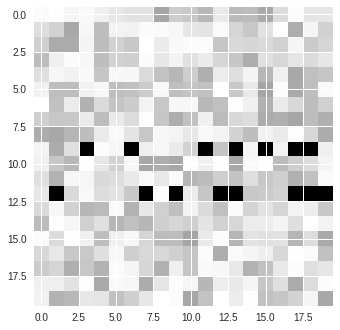

-- 70 --


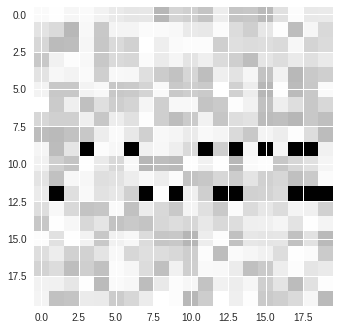

-- 80 --


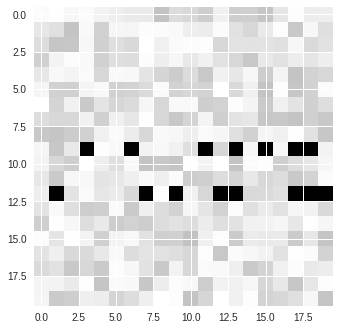

-- 90 --


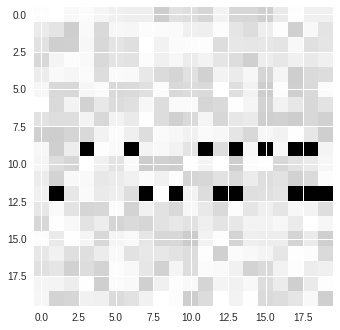

In [5]:
# active dendrite based model
# one of the inspiration is {Hawkins2016}

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

C = 10      # number of columns
N = 5       # neurons per column
D = 20      # dendrites per neuron
S = 20      # max potential synapses per dendrite
I = 100     # input embedding size

def generate_embedding(symbol):
  e = torch.ByteTensor(I).random_(0, 100)
  sparsity = 0.2
  e[e < 100 * sparsity] = 1
  e[e >= 100 * sparsity] = 0
  return e

def generate_embeddings(symbols):
  return dict((s, generate_embedding(s)) for s in symbols)

embeddings = generate_embeddings(['A', 'B', 'C', 'D', 'X', 'Y', 'E', 'F', 'G', 'H', 'I', 'J', 'K'])

# receptive field
receptive_field_input_indices = torch.LongTensor(C, N, D, S).random_(0, I)
receptive_field_weights = torch.DoubleTensor(C, N, D, S).uniform_(0, 1)
# print(receptive_field_weights)

def get_active_indices(rfii, rfw, inp):
  rf = rfii.view(-1, rfii.shape[-1])
  rfw = rfw.view(-1, rfw.shape[-1])

  values = torch.stack([torch.index_select(inp, 0, indices) for indices in rf])
  values[rfw < 0.3] = 0

  return values.view(rfii.shape)

def step(receptive_field_input_indices, receptive_field_weights, input, debug=False):
  # if debug:
  #   print("input", input)
    # print("receptive_field_input_indices", receptive_field_input_indices)
    # print("receptive_field_weights", receptive_field_weights)
  active_indices = get_active_indices(receptive_field_input_indices, receptive_field_weights, input)
  dendrite_activations = active_indices.sum(dim=-1)
  dendrite_activations[dendrite_activations < 4] = 0
  # print("dendrite_activations.shape", dendrite_activations.shape)
  neuron_activations, max_activated_dendrite_indices = dendrite_activations.max(-1)
  column_activations, max_activated_neuron_indices = neuron_activations.max(-1)
  _, max_activated_column_indices = column_activations.topk(10, dim=-1)

  # if debug:
    # print("dendrite_activations", dendrite_activations)
    # print("neuron_activations", neuron_activations)
    # print("max_activated_dendrite_indices", max_activated_dendrite_indices)
    # print("column_activations", column_activations)
    # print("max_activated_neuron_indices", max_activated_neuron_indices)

  winning_column_indices = max_activated_column_indices
  winning_neuron_indices = max_activated_neuron_indices.index_select(0, winning_column_indices)
  wdi = max_activated_dendrite_indices.index_select(0, winning_column_indices)
  winning_dendrite_indices = torch.stack([wdi[i, winning_neuron_indices[i]] for i in range(winning_neuron_indices.shape[-1])])

  receptive_field_weights *= 0.999
  winning_dendrite_full_indices = torch.as_tensor([i for i in zip(winning_column_indices, winning_neuron_indices, winning_dendrite_indices)])
  # if debug:
    # print("winning_column_indices", winning_column_indices)
    # print("winning_neuron_indices", winning_neuron_indices)
    # print("winning_dendrite_indices", winning_dendrite_indices)
    # print("winning_dendrite_full_indices", winning_dendrite_full_indices)
    # print("receptive_field_weights.shape", receptive_field_weights.shape)

  for i in range(winning_dendrite_full_indices.shape[0]):
    dendrite_active_synapses = active_indices[tuple(winning_dendrite_full_indices[i])] >= 1
    receptive_field_weights[tuple(winning_dendrite_full_indices[i])][dendrite_active_synapses] /= 0.95

  receptive_field_weights[receptive_field_weights > 1] = 1

for i in range(100):
  debug = i % 10 == 0
  if debug:
    print(f"-- {i} --")

  for symbol in embeddings:
    step(receptive_field_input_indices, receptive_field_weights, embeddings[symbol], debug=debug)

  if debug:
    plt.figure('weights')
    plt.imshow(receptive_field_weights[0, 0], vmin=0, vmax=1)
    plt.pause(0.001)

plt.show()


This script shows how an active dendrite based model will results in sparse representation of inputs. We use inputs that are binary vectors of length 100 with approx 20 "1"s, rest "0"s, i.e. highly sparse representations.

After training, each input results in specific dendrites on specific neurons in specific columns to become active. The image output shows 20 dendrites with 20 synapses each for neuron 0 in column 0. Notice that synapses that make the dendrite active have high stength (dark) connections after training.